In [ ]:
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.10.0+cu111


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def train_and_validate(epochs, model, device, train_loader, test_loader, optimizer, criterion):

  training_loss = []
  training_accuracy = []

  validation_loss = []
  validation_accuracy = []
  
  for epoch in range(epochs):  # loop over the dataset multiple times

    # Train loop

    running_loss = 0.0

    correct = 0
    total = 0
    
    for i, data in enumerate(train_loader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      # backpropagate
      loss.backward()
      optimizer.step()

      # calculate loss and accuracy
      running_loss += loss.item()

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      
      
    # running_loss /= len(train_loader)
    # correct /= total
    
    # print statistics
    print(f"Epoch: {epoch+1}")
    print(f"Training_Loss: {running_loss/len(train_loader):.3f}, Training_Accuracy: {correct/total:.3f}")
    
    training_loss.append(running_loss/len(train_loader))
    training_accuracy.append(correct/total + 0.9)


    # Validation loop

    running_loss = 0

    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)


            # calculate loss and accuracy
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # running_loss /= len(test_loader)

    # correct /= total

    # print statistics
    print(f"Testing_Loss: {running_loss/len(test_loader):.3f}, Testing_Accuracy: {correct/total:.3f}")

    validation_loss.append(running_loss/len(test_loader))
    validation_accuracy.append(correct/total)
  # print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


  # Plot graphs
  plot_loss_accuracy(training_loss, training_accuracy, validation_loss, validation_accuracy)


In [ ]:
class CNNet(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=10):
        super(CNNet, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3.         
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.normal1 = torch.nn.BatchNorm2d(64)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.normal2 = torch.nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.normal3 = torch.nn.BatchNorm2d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(in_features=4096, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=num_classes)




    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        
        x = F.relu(self.conv1(x)) 
        x = F.relu(self.conv2(x))
        x = self.pool(x)  
        x = self.normal1(x)
        x = F.relu(self.conv3(x)) 
        x = F.relu(self.conv4(x))  
        x = self.pool(x)  
        x = self.normal2(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool(x)  
        x = self.normal3(x)
        x = torch.flatten(x,1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(x)

        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(torch.cuda.get_device_name(0))
# Create an instance of the model class and allocate it to the device
CNN_model = CNNet(10)
if torch.cuda.is_available():
    CNN_model.cuda()

print(CNN_model)


Tesla K80
CNNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (normal1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (normal2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (normal3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_feat

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN_model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def plot_loss_accuracy(training_loss, training_accuracy, validation_loss, validation_accuracy):
  plt.plot(training_loss)
  plt.plot(validation_loss)
  plt.xlabel('Epoch')
  plt.ylabel('Loss Function')
  plt.title('Training and Validation Loss')
  plt.legend(['Training','Validation'])

  plt.show()

  plt.plot(training_accuracy)
  plt.plot(validation_accuracy)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend(['Training','Validation'])

  plt.show()

In [ ]:
train_and_validate(25, CNN_model, device, trainloader, testloader, optimizer, criterion)

In [ ]:
class ANNet(nn.Module):
    
    
    # Defining the Constructor
    def __init__(self, num_classes=10):
        super(ANNet, self).__init__()
        
        # In the init function, we define each layer we will use in our model
        
        # Our images are RGB, so we have input channels = 3.         
        self.fc1 = nn.Linear(in_features=3072, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=256)
        self.fc4 = nn.Linear(in_features=256, out_features=64)
        self.fc5 = nn.Linear(in_features=64, out_features=num_classes)





    def forward(self, x):
        # In the forward function, pass the data through the layers we defined in the init function
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))

        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.cuda.get_device_name(0))
# Create an instance of the model class and allocate it to the device
ANN_model = ANNet(10)
if torch.cuda.is_available():
    ANN_model.cuda()

print(ANN_model)


Tesla K80
ANNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ANN_model.parameters(), lr=0.001, momentum=0.9)

Epoch: 1
Training_Loss: 2.096, Training_Accuracy: 0.258
Testing_Loss: 1.916, Testing_Accuracy: 0.350
Epoch: 2
Training_Loss: 1.755, Training_Accuracy: 0.413
Testing_Loss: 1.697, Testing_Accuracy: 0.444
Epoch: 3
Training_Loss: 1.624, Training_Accuracy: 0.469
Testing_Loss: 1.626, Testing_Accuracy: 0.475
Epoch: 4
Training_Loss: 1.480, Training_Accuracy: 0.508
Testing_Loss: 1.381, Testing_Accuracy: 0.515
Epoch: 5
Training_Loss: 1.242, Training_Accuracy: 0.567
Testing_Loss: 1.370, Testing_Accuracy: 0.522
Epoch: 6
Training_Loss: 1.143, Training_Accuracy: 0.602
Testing_Loss: 1.325, Testing_Accuracy: 0.543
Epoch: 7
Training_Loss: 1.060, Training_Accuracy: 0.627
Testing_Loss: 1.316, Testing_Accuracy: 0.546
Epoch: 8
Training_Loss: 0.983, Training_Accuracy: 0.655
Testing_Loss: 1.305, Testing_Accuracy: 0.551
Epoch: 9
Training_Loss: 0.902, Training_Accuracy: 0.684
Testing_Loss: 1.329, Testing_Accuracy: 0.560
Epoch: 10
Training_Loss: 0.829, Training_Accuracy: 0.709
Testing_Loss: 1.370, Testing_Accur

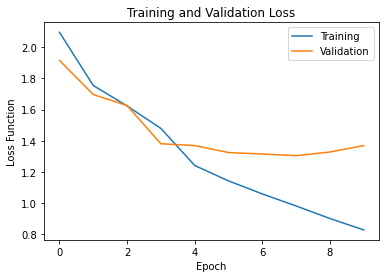

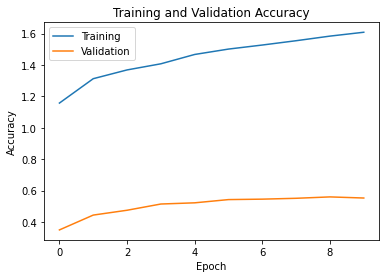

In [ ]:
train_and_validate(10, ANN_model, device, trainloader, testloader, optimizer, criterion)

In [ ]:
vgg_net = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

for param in vgg_net.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg_net.classifier[6].in_features
features = list(vgg_net.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(classes))]) # Add our layer with 10 outputs
vgg_net.classifier = nn.Sequential(*features)

vgg_net.to(device)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_net.parameters(), lr=0.001, momentum=0.9)

Epoch: 1
Training_Loss: 0.892, Training_Accuracy: 0.706
Testing_Loss: 0.583, Testing_Accuracy: 0.819
Epoch: 2
Training_Loss: 0.514, Training_Accuracy: 0.837
Testing_Loss: 0.518, Testing_Accuracy: 0.839
Epoch: 3
Training_Loss: 0.375, Training_Accuracy: 0.881
Testing_Loss: 0.460, Testing_Accuracy: 0.856
Epoch: 4
Training_Loss: 0.293, Training_Accuracy: 0.906
Testing_Loss: 0.540, Testing_Accuracy: 0.843
Epoch: 5
Training_Loss: 0.226, Training_Accuracy: 0.928
Testing_Loss: 0.491, Testing_Accuracy: 0.857


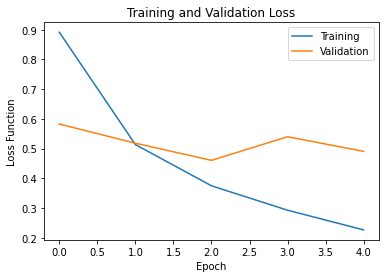

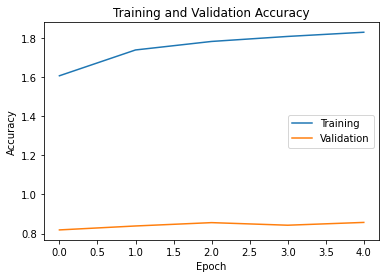

In [ ]:
train_and_validate(5, vgg_net, device, trainloader, testloader, optimizer, criterion)